In [83]:
import numpy as np
import pandas as pd
from collections import OrderedDict

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

In [84]:
data = pd.read_csv("/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/NL_data/train_set/processed_data.csv")

In [85]:
data.head()

,time,latitude,longitude,surface,u10,v10,d2m,t2m,sp,tcc,...,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_6,hour_12,hour_18
0,2022-01-01 00:00:00,53.5,3.50,0.0,8.629013,4.519394,282.46686,283.44373,101881.06,0.964813,...,False,False,False,False,False,False,True,False,False,False
1,2022-01-01 00:00:00,53.5,3.75,0.0,8.801865,4.296738,282.50006,283.48083,101887.06,0.956665,...,False,False,False,False,False,False,True,False,False,False
2,2022-01-01 00:00:00,53.5,4.00,0.0,8.822372,4.069199,282.50397,283.51013,101897.06,0.951111,...,False,False,False,False,False,False,True,False,False,False
3,2022-01-01 00:00:00,53.5,4.25,0.0,8.698349,3.783066,282.50983,283.52966,101910.06,0.972260,...,False,False,False,False,False,False,True,False,False,False
4,2022-01-01 00:00:00,53.5,4.50,0.0,8.562607,3.510605,282.46490,283.48083,101917.06,0.997406,...,False,False,False,False,False,False,True,False,False,False


In [86]:
data_ams = data[(data['latitude'] == 52.25) & (data['longitude'] == 5.)]
data_ams.shape

(20452, 29)

In [87]:
# data_ams['time'] = pd.to_datetime(data_ams['time'], format='%Y-%m-%d %H:%M:%S')

# data_ams['days'] = (pd.Timestamp('20220101') - data_ams['time']).dt.days
# data_ams['month'] = data_ams['time'].dt.month
# data_ams['hour'] = data_ams['time'].dt.hour
# Sort values by time and set time as index
data_ams = data_ams.sort_values(by='time').set_index('time')

data_ams = data_ams.drop(['latitude', 'longitude', 'surface', 'step', 'number', 'valid_time', 'd2m'], axis=1)

In [88]:
# this just moves temp to the right of the DF, easier for X / y split
data_ams['temp'] = data_ams['t2m']
data_ams = data_ams.drop(['t2m'], axis = 1)

In [89]:
data_ams.tail(10)

,u10,v10,sp,tcc,month_1,month_2,month_3,month_4,month_5,month_6,...,month_8,month_9,month_10,month_11,month_12,hour_0,hour_6,hour_12,hour_18,temp
time,,,,,,,,,,,,,,,,,,,,,
2023-12-29 12:00:00,7.698029,3.385040,100608.250,0.994232,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,284.09937
2023-12-29 18:00:00,6.316650,1.796372,100525.690,0.934692,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,281.20825
2023-12-30 00:00:00,7.372772,1.342194,100804.875,0.204254,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,281.02783
2023-12-30 06:00:00,5.548935,2.163406,101051.190,0.669281,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,279.99713
2023-12-30 12:00:00,3.049789,4.710754,101141.810,0.799286,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,281.88336
2023-12-30 18:00:00,1.118652,6.455353,100824.500,1.000000,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,282.27588
2023-12-31 00:00:00,0.214554,7.665054,100316.190,1.000000,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,282.66920
2023-12-31 06:00:00,-2.000854,7.253052,99546.810,1.000000,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,282.51940
2023-12-31 12:00:00,3.577621,7.112122,99374.310,0.878143,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,281.82178


In [90]:
train_split = round(len(data_ams) * 0.8)
train_set = data_ams.iloc[:train_split, :]
valid_set = data_ams.iloc[train_split:, :]
print(train_set.shape)
print(valid_set.shape)

(16362, 21)
(4090, 21)


In [91]:
# Prepare dataset

# def prepare_data(raw_data, interval):
#     X, y = [], []
#     for i in range(interval, len(raw_data)):
#         X.append(raw_data.iloc[i - interval:i, :])
#         y.append(raw_data.iloc[i, 3])
#     return np.array(X), np.array(y)

#split into x and y
X_train, Y_train = train_set.iloc[:, :-1], train_set['temp']
X_valid, Y_valid = valid_set.iloc[:, :-1], valid_set['temp']

In [92]:
# X, y = prepare_data(data_ams, 30)

# X.shape, y.shape

In [93]:
# y[-10:]

In [94]:
# X = data_ams.drop(['t2m'], axis=1)
# y = data_ams['t2m']

# X.shape, y.shape

In [95]:
# X_train, X_valid, y_train, y_valid = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=0)

In [96]:
X_train.shape, Y_train.shape

((16362, 20), (16362,))

In [97]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "warm_start":True,
    "oob_score":True,
    "random_state": 42,
}

In [98]:
reg = RandomForestRegressor(**params)

In [99]:
reg.fit(X_train, Y_train)

RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=500,
                      oob_score=True, random_state=42, warm_start=True)

In [100]:
y_pred = reg.predict(X_valid)

In [101]:
# Evaluation
mse = mean_squared_error(Y_valid, y_pred)
train_score = round(reg.score(X_train, Y_train) * 100, 2)
valid_score = round(reg.score(X_valid, Y_valid) * 100, 2)

print('Mean Squared Error (MSE):', mse)

Mean Squared Error (MSE): 19.401119484430126


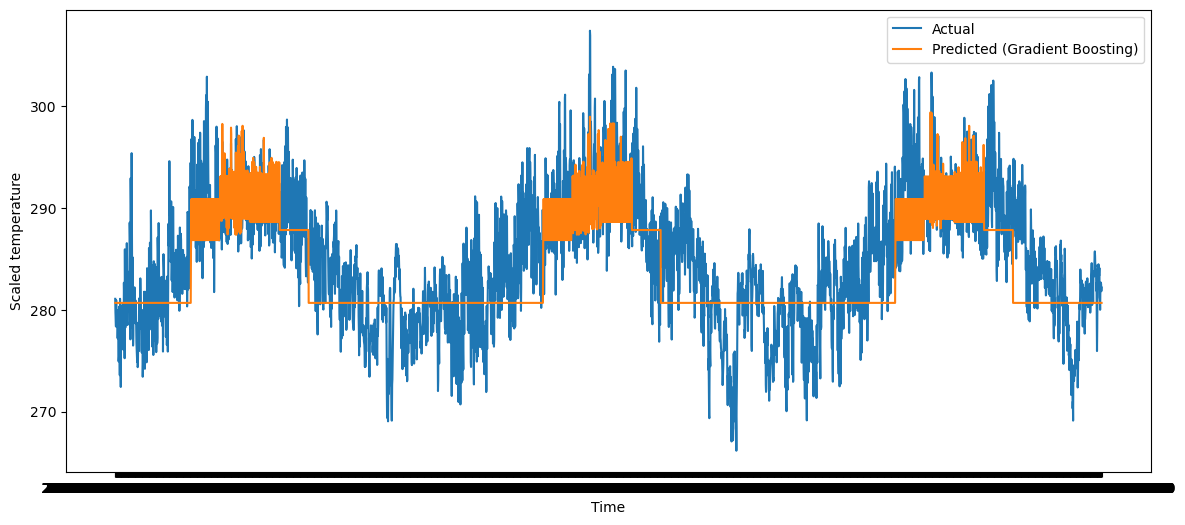

In [102]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(Y_valid, label='Actual')
plt.plot(y_pred, label='Predicted (Gradient Boosting)')
plt.xlabel('Time')
plt.ylabel('Scaled temperature') #in this case

plt.legend()
plt.show()

In [103]:
# Load the test data (2024)
nl_test_df = pd.read_csv('/Users/jesselemeer/Documents/GitHub/Project2-2/Project_2-2/NL_data/test_set/processed_data.csv')

# Filter data for Amsterdam
ams_test_df = nl_test_df[(nl_test_df['latitude'] == 52.25) & (nl_test_df['longitude'] == 5.)]

# Sort values by time and set time as index
ams_test_df = ams_test_df.sort_values(by='time').set_index('time')

# Drop unnecessary columns
ams_test_df = ams_test_df.drop(['latitude', 'longitude', 'surface', 'step', 'number', 'valid_time', 'd2m'], axis=1)

# Rename 't2m' column to 'temp'
# ams_df.rename(columns={'t2m': 'temp'}, inplace=True)

# this just moves temp to the right of the DF, easier for X / y split
ams_test_df['temp'] = ams_test_df['t2m']
ams_test_df = ams_test_df.drop(['t2m'], axis = 1)

In [104]:
#split into x and y
X_test, Y_test = ams_test_df.iloc[:, :-1], ams_test_df['temp']

In [105]:
best_Y_pred = reg.predict(X_test)

In [106]:

best_mse = mean_squared_error(Y_test, best_Y_pred)

print("Best mean squared error:", best_mse)


Best mean squared error: 18.80118673152537


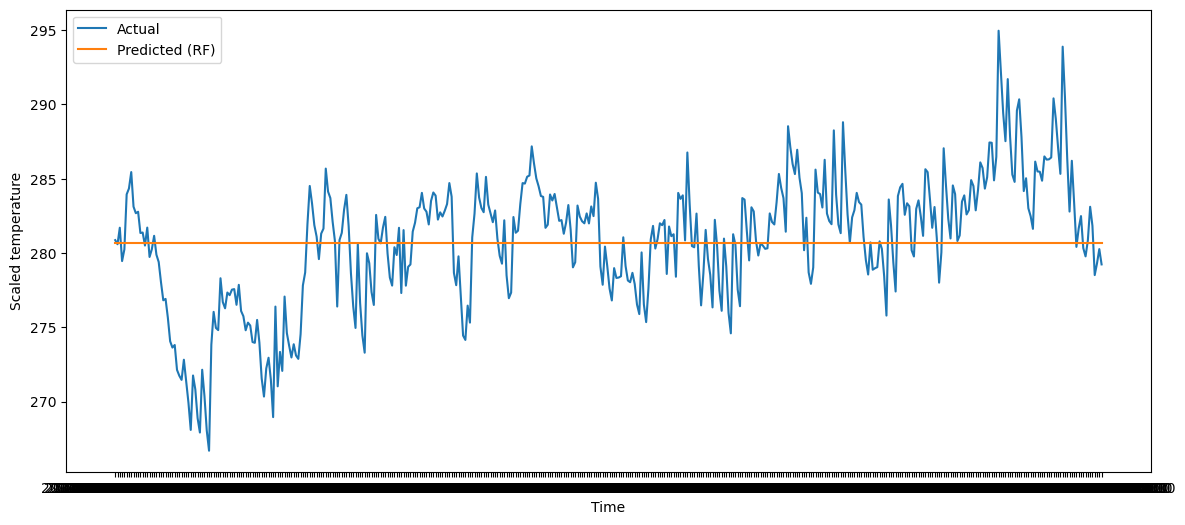

In [108]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(Y_test, label='Actual')
plt.plot(best_Y_pred, label='Predicted (RF)')
plt.xlabel('Time')
plt.ylabel('Scaled temperature') #in this case

plt.legend()
plt.show()